In [1]:
import os

import numpy as np
import pandas as pd
from scipy.stats import gamma, norm, lognorm, binom
from pyarrow import parquet
from matplotlib import pyplot as plt


plt.style.use('blackontrans')

In [2]:
DATA_PATH = "/home/matt/Desktop/nba_data/parsed_pbpstats"

# filters = [[('year', '=', '2017-18'), ('season_type', '=', 'Regular Season')]]
filters = [[('season_type', '=', 'Regular Season')]]
# filters = None
possessions = parquet.read_table(DATA_PATH, filters=filters).to_pandas()

In [3]:
def process_possessions(possessions):
    # aggregate possessions per game & offense
    games = possessions.groupby(by=['game_id', 'off_team_id'], as_index=False).agg({
        'def_team_id': 'first',
        'home_team_id': 'first',
        'year': 'first',
        'date': 'first',
        'turnovers': 'sum',
        'threes_attempted': 'sum',
        'threes_made': 'sum',
        'twos_attempted': 'sum',
        'twos_made': 'sum',
        'ft_attempted': 'sum',
        'ft_made': 'sum',
        'off_rebs': 'sum',
        'def_rebs': 'sum',
        'points_scored': 'sum',
        'duration': 'sum',
        'possesion_num': 'count',
        'period': 'max',
    })

    # calculate rate statistics
    games['three_make_rate'] = games['threes_made'] / games['threes_attempted']
    games['two_make_rate'] = games['twos_made'] / games['twos_attempted']
    games['three_attempt_rate'] = games['threes_attempted'] / (games['twos_attempted'] + games['threes_attempted'])
    games['ft_attempt_rate'] = games['ft_attempted'] / games['possesion_num']
    games['ft_make_rate'] = games['ft_made'] / games['ft_attempted']
    games['off_reb_rate'] = games['off_rebs'] / (games['off_rebs'] + games['def_rebs'])
    games['turnover_rate'] = games['turnovers'] / games['possesion_num']
    games['pace'] = games['duration'] / games['possesion_num']
    games['shot_rate'] = (games['threes_attempted'] + games['twos_attempted']) / (games['off_rebs'] + games['possesion_num'])
    games['attempt_rate'] = (games['twos_attempted'] + games['threes_attempted']) / games['possesion_num']
    games['scoring_rate'] = games['points_scored'] / games['possesion_num']

    # estimate scoring rate based on underlying rate statistics
    games['shot_rate_est'] = estimate_shot_rate(
        games['turnover_rate'],
        games['ft_attempt_rate'],
    )
    games['attempt_rate_est'] = estimate_attempt_rate(
        games['shot_rate_est'],
        games['three_attempt_rate'],
        games['three_make_rate'],
        games['two_make_rate'],
        games['off_reb_rate'],
    )
    games['scoring_rate_est'] = calc_scoring_rate(
        games['attempt_rate_est'],
        games['three_make_rate'],
        games['two_make_rate'],
        games['three_attempt_rate'],
        games['ft_attempt_rate'],
        games['ft_make_rate'],
    )

    return games


def estimate_shot_rate(turnover_rate, ft_attempt_rate):
    """
    Estimates shot_rate: shot attempts per potential shot attempt event, i.e.
    possessions plus offensive rebounds. Coefficients are rounded
    from a simple least-squared regression from regular-season data.
    """
    return 1 - 0.85 * turnover_rate - 0.4 * ft_attempt_rate


def estimate_attempt_rate(shot_rate, three_attempt_rate, three_make_rate, two_make_rate, off_reb_rate):
    """
    Estimates attempt_rate (shot attempts per possession) given a shot_rate
    (see above for definition), then taking into account how frequently shots are missed
    and rebounded by the offense.
    """
    no_shot_rate = 1 - shot_rate
    make_rate = three_attempt_rate * three_make_rate + (1 - three_attempt_rate) * two_make_rate
    miss_rate = 1 - make_rate
    def_reb_rate = 1 - off_reb_rate

    restart_possession = shot_rate * miss_rate * off_reb_rate
    last_shot = shot_rate * (make_rate + miss_rate * (def_reb_rate + off_reb_rate * no_shot_rate))
    return last_shot  / (1 - restart_possession) ** 2


def calc_scoring_rate(attempt_rate, three_make_rate, two_make_rate, three_attempt_rate, ft_attempt_rate, ft_make_rate):
    """Calculates points per possession from underlying rate statistics"""
    points_per_attempt = 3 * three_attempt_rate * three_make_rate + 2 * (1 - three_attempt_rate) * two_make_rate
    return attempt_rate * points_per_attempt + ft_attempt_rate * ft_make_rate


games = process_possessions(possessions)

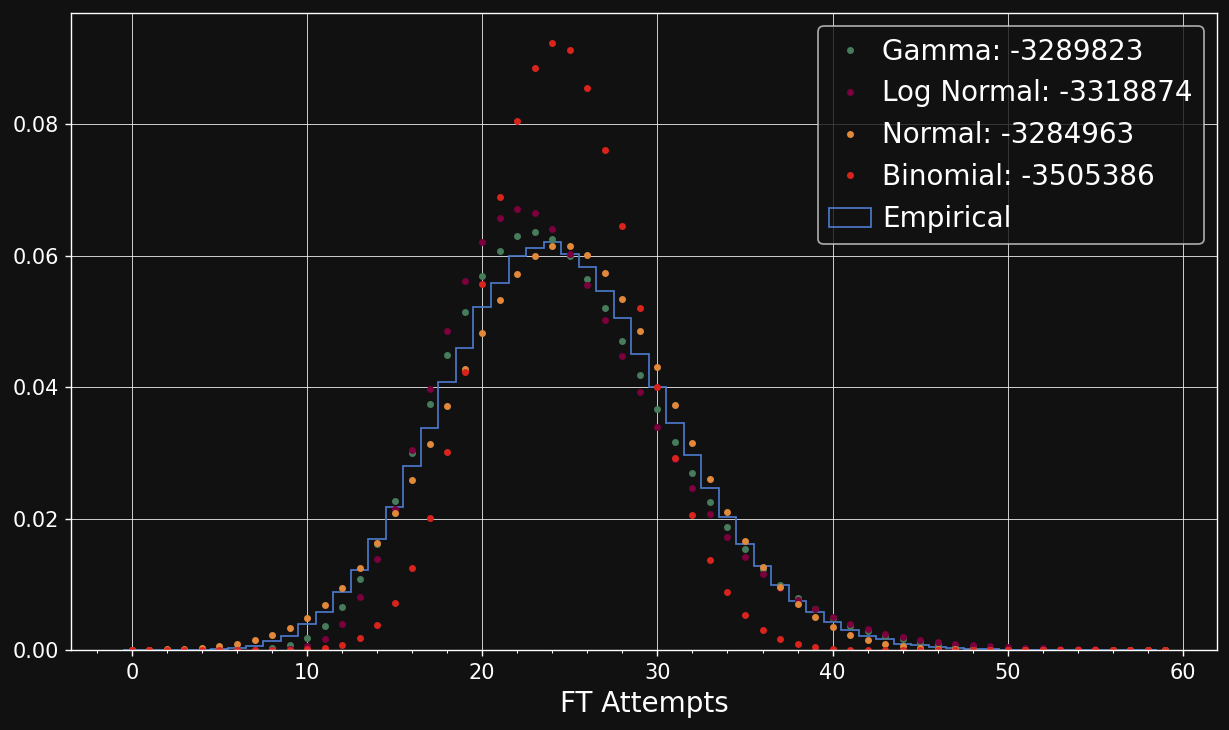

In [5]:
n_trials = 1000000
n_possessions = 100

ft_attempted = possessions['ft_attempted'].value_counts().sort_index().values / possessions.shape[0]

ft_sims = np.random.choice(ft_attempted.shape[0], size=(n_trials, n_possessions), p=ft_attempted).sum(1)
support = np.arange(ft_sims.max())
mu = ft_sims.mean()
sigma = ft_sims.std()

gamma_dist = gamma(a=mu ** 2 / sigma ** 2, scale=sigma ** 2 / mu)
lognorm_dist = lognorm(s=np.sqrt(np.log(1 + sigma ** 2 / mu ** 2)), scale=mu ** 2 / np.sqrt(sigma ** 2 + mu ** 2))
norm_dist = norm(loc=mu, scale=sigma)
binom_dist = binom(n=n_possessions, p=mu / n_possessions)

gamma_score = gamma_dist.logpdf(ft_sims).sum()
lognorm_score = lognorm_dist.logpdf(ft_sims).sum()
norm_score = norm_dist.logpdf(ft_sims).sum()
binom_score = binom_dist.logpmf(ft_sims).sum()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(ft_sims, bins=support, rwidth=0.8, label='Empirical', density=True, histtype='step', align='left')
ax.plot(support, gamma_dist.pdf(support), '.', label=f'Gamma: {gamma_score:.0f}')
ax.plot(support, lognorm_dist.pdf(support), '.', label=f'Log Normal: {lognorm_score:.0f}')
ax.plot(support, norm_dist.pdf(support), '.', label=f'Normal: {norm_score:.0f}')
ax.plot(support, binom_dist.pmf(support), '.', label=f'Binomial: {binom_score:.0f}')
ax.set_xlabel('FT Attempts')
ax.legend();

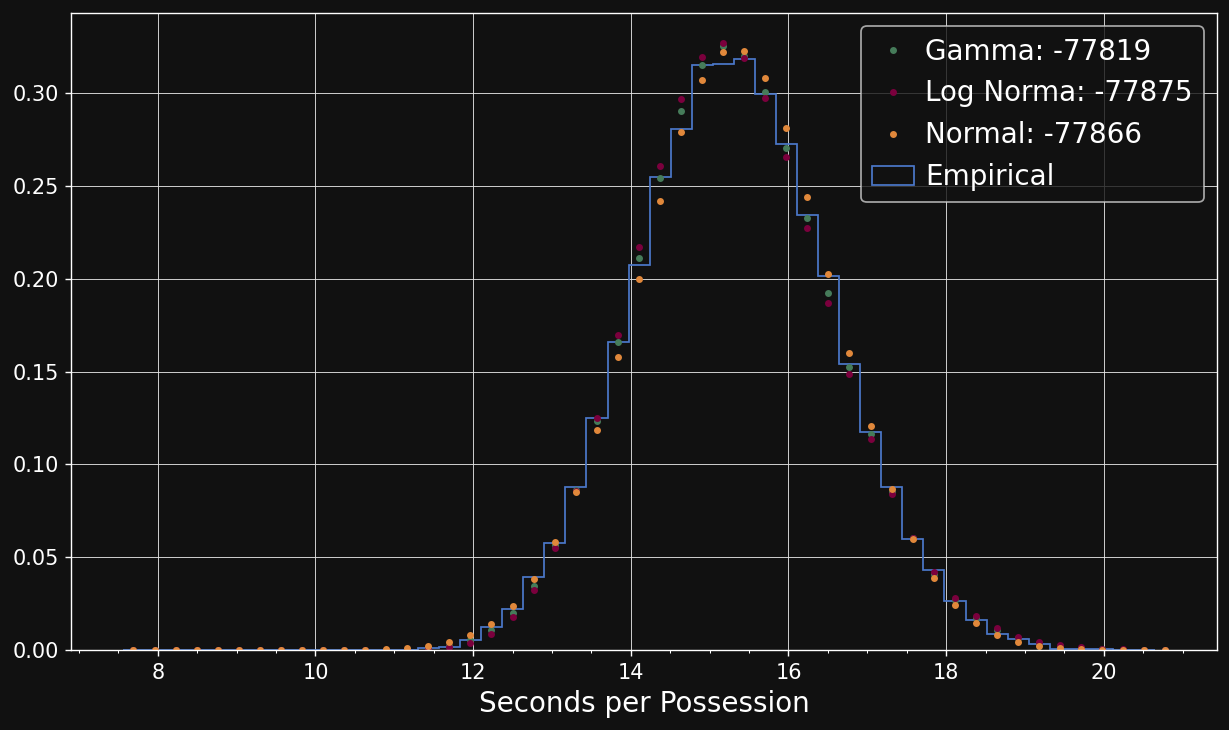

In [6]:
pace = games['pace']

support = np.linspace(pace.min(), pace.max())
shift = (support[-1] - support[0]) / support.shape[0] / 2
x = support + shift
mu = pace.mean()
sigma = pace.std()

gamma_dist = gamma(a=mu ** 2 / sigma ** 2, scale=sigma ** 2 / mu)
lognorm_dist = lognorm(s=np.sqrt(np.log(1 + sigma ** 2 / mu ** 2)), scale=mu ** 2 / np.sqrt(sigma ** 2 + mu ** 2))
norm_dist = norm(loc=mu, scale=sigma)

gamma_score = gamma_dist.logpdf(pace).sum()
lognorm_score = lognorm_dist.logpdf(pace).sum()
norm_score = norm_dist.logpdf(pace).sum()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(pace, bins=support, label='Empirical', density=True, histtype='step')
ax.plot(x, gamma_dist.pdf(x), '.', label=f'Gamma: {gamma_score:.0f}')
ax.plot(x, lognorm_dist.pdf(x), '.', label=f'Log Norma: {lognorm_score:.0f}')
ax.plot(x, norm_dist.pdf(x), '.', label=f'Normal: {norm_score:.0f}')
ax.set_xlabel('Seconds per Possession')
ax.legend();

In [7]:
filt = games['off_team_id'] == games['home_team_id']

hc_three_make_rate = games.loc[filt, 'threes_made'].sum() / games.loc[filt, 'threes_attempted'].sum()
hc_two_make_rate = games.loc[filt, 'twos_made'].sum() / games.loc[filt, 'twos_attempted'].sum()
hc_three_attempt_rate = games.loc[filt, 'threes_attempted'].sum() / (games.loc[filt, 'twos_attempted'].sum() + games.loc[filt, 'threes_attempted'].sum())
hc_ft_attempt_rate = games.loc[filt, 'ft_attempted'].sum() / games.loc[filt, 'possesion_num'].sum()
hc_ft_make_rate = games.loc[filt, 'ft_made'].sum() / games.loc[filt, 'ft_attempted'].sum()
hc_off_reb_rate = games.loc[filt, 'off_rebs'].sum() / (games.loc[filt, 'off_rebs'].sum() + games.loc[filt, 'def_rebs'].sum())
hc_turnover_rate = games.loc[filt, 'turnovers'].sum() / games.loc[filt, 'possesion_num'].sum()
hc_pace = games.loc[filt, 'duration'].sum() / games.loc[filt, 'possesion_num'].sum()
hc_shot_rate = (games.loc[filt, 'threes_attempted'].sum() + games.loc[filt, 'twos_attempted'].sum()) / (games.loc[filt, 'off_rebs'].sum() + games.loc[filt, 'possesion_num'].sum())
hc_attempt_rate = (games.loc[filt, 'twos_attempted'].sum() + games.loc[filt, 'threes_attempted'].sum()) / games.loc[filt, 'possesion_num'].sum()
hc_scoring_rate = games.loc[filt, 'points_scored'].sum() / games.loc[filt, 'possesion_num'].sum()
hc_est_shot_rate = estimate_shot_rate(hc_turnover_rate, hc_ft_attempt_rate)
hc_est_attempt_rate = estimate_attempt_rate(hc_est_shot_rate, hc_three_attempt_rate, hc_three_make_rate, hc_two_make_rate, hc_off_reb_rate)
hc_est_scoring_rate = calc_scoring_rate(hc_est_attempt_rate, hc_three_make_rate, hc_two_make_rate, hc_three_attempt_rate, hc_ft_attempt_rate, hc_ft_make_rate)

away_three_make_rate = games.loc[~filt, 'threes_made'].sum() / games.loc[~filt, 'threes_attempted'].sum()
away_two_make_rate = games.loc[~filt, 'twos_made'].sum() / games.loc[~filt, 'twos_attempted'].sum()
away_three_attempt_rate = games.loc[~filt, 'threes_attempted'].sum() / (games.loc[~filt, 'twos_attempted'].sum() + games.loc[~filt, 'threes_attempted'].sum())
away_ft_attempt_rate = games.loc[~filt, 'ft_attempted'].sum() / games.loc[~filt, 'possesion_num'].sum()
away_ft_make_rate = games.loc[~filt, 'ft_made'].sum() / games.loc[~filt, 'ft_attempted'].sum()
away_off_reb_rate = games.loc[~filt, 'off_rebs'].sum() / (games.loc[~filt, 'off_rebs'].sum() + games.loc[~filt, 'def_rebs'].sum())
away_turnover_rate = games.loc[~filt, 'turnovers'].sum() / games.loc[~filt, 'possesion_num'].sum()
away_pace = games.loc[~filt, 'duration'].sum() / games.loc[~filt, 'possesion_num'].sum()
away_shot_rate = (games.loc[~filt, 'threes_attempted'].sum() + games.loc[~filt, 'twos_attempted'].sum()) / (games.loc[~filt, 'off_rebs'].sum() + games.loc[~filt, 'possesion_num'].sum())
away_attempt_rate = (games.loc[~filt, 'twos_attempted'].sum() + games.loc[~filt, 'threes_attempted'].sum()) / games.loc[~filt, 'possesion_num'].sum()
away_scoring_rate = games.loc[~filt, 'points_scored'].sum() / games.loc[~filt, 'possesion_num'].sum()
away_est_shot_rate = estimate_shot_rate(away_turnover_rate, away_ft_attempt_rate)
away_est_attempt_rate = estimate_attempt_rate(away_est_shot_rate, away_three_attempt_rate, away_three_make_rate, away_two_make_rate, away_off_reb_rate)
away_est_scoring_rate = calc_scoring_rate(away_est_attempt_rate, away_three_make_rate, away_two_make_rate, away_three_attempt_rate, away_ft_attempt_rate, away_ft_make_rate)

print(f'Three Make Rate: {hc_three_make_rate * 1e2:.1f}% - {away_three_make_rate * 1e2:.1f}% ')
print(f'Two Make Rate: {hc_two_make_rate * 1e2:.1f}% - {away_two_make_rate * 1e2:.1f}% ')
print(f'FT Attempt Rate: {hc_ft_attempt_rate * 1e2:.1f} - {away_ft_attempt_rate * 1e2:.1f}')
print(f'FT Make Rate: {hc_ft_make_rate * 1e2:.1f}% - {away_ft_make_rate * 1e2:.1f}% ')
print(f'Off Reb Rate: {hc_off_reb_rate * 1e2:.1f}% - {away_off_reb_rate * 1e2:.1f}% ')
print(f'Turnover Rate: {hc_turnover_rate * 1e2:.1f}% - {away_turnover_rate * 1e2:.1f}% ')
print(f'Pace: {hc_pace:.1f}s - {away_pace:.1f}s ')
print(f'Shot Rate: {hc_shot_rate * 1e2:.1f} - {away_shot_rate * 1e2:.1f} ')
print(f'Attempt Rate: {hc_attempt_rate * 1e2:.1f} - {away_attempt_rate * 1e2:.1f} ')
print(f'Scoring Rate: {hc_scoring_rate * 1e2:.1f} - {away_scoring_rate * 1e2:.1f} ')
print(f'Estimated Shot Rate: {hc_est_shot_rate * 1e2:.1f} - {away_est_shot_rate * 1e2:.1f} ')
print(f'Estimated Attempt Rate: {hc_est_attempt_rate * 1e2:.1f} - {away_est_attempt_rate * 1e2:.1f} ')
print(f'Estimated Scoring Rate: {hc_est_scoring_rate * 1e2:.1f} - {away_est_scoring_rate * 1e2:.1f} ')

Three Make Rate: 36.0% - 35.3% 
Two Make Rate: 49.1% - 47.8% 
FT Attempt Rate: 25.0 - 24.0
FT Make Rate: 75.7% - 75.5% 
Off Reb Rate: 28.8% - 27.7% 
Turnover Rate: 15.0% - 15.4% 
Pace: 15.2s - 15.3s 
Shot Rate: 76.1 - 76.2 
Attempt Rate: 86.8 - 86.7 
Scoring Rate: 106.3 - 103.2 
Estimated Shot Rate: 77.2 - 77.3 
Estimated Attempt Rate: 87.7 - 87.7 
Estimated Scoring Rate: 107.3 - 104.2 
